<a href="https://colab.research.google.com/github/Rpvermaak/datakit-smallholder-farmers-fall-2025/blob/main/Challenge%201%20_Weather%20Patterns/Ruben%20Vermaak/Challenge_1_Identifying_patterns_in_weather_and_agriculture_ruben_vermaak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Challenge 1 - Identifying patterns in weather and agriculture

**Goal:** Understand how weather patterns affect the types of questions farmers ask.

**Context:** Producers Direct suspects that certain weather events (e.g., drought, heavy rain, heatwaves) influence the questions farmers post.  For example, more pest-related questions during rainy periods.

**Guiding Questions:**
* How do question volumes or topics change during specific weather conditions (rain, heat, drought, etc.)?
* Can we predict the kinds of questions likely to appear given a weather forecast?
* Are certain crops or regions more sensitive to weather-driven question patterns?

**Suggested Outputs:**
* A time series visualization linking weather events and question frequency/topics
* A short summary of insights (e.g., “Pest questions spike 2 weeks after heavy rainfall”)
* Stretch goal: a predictive model that forecasts question categories based on forecasted weather

**Data for this challenge:**
[Producers Direct dataset](https://producersdirect-backups.s3.eu-west-1.amazonaws.com/athena-results/Unsaved/2025/09/26/b0cd514b-b9cc-4972-a0c2-c91726e6d825.csv)
Historic weather data- explore datasets [here](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily)
Kenya - [explore data here](https://climateknowledgeportal.worldbank.org/country/kenya/climate-data-historical)
Uganda- [explore data here](https://climateknowledgeportal.worldbank.org/country/uganda/climate-data-historical)
Tanzania- [explore data here](https://climateknowledgeportal.worldbank.org/country/tanzania/climate-data-historical)



## Data Pipeline & Reproducibility Notes

To ensure efficiency and full reproducibility, the data was processed in two primary stages:

### 1. Local Data Preprocessing & Optimization

* **File Conversion:** The raw producer data and the cleaned weather data were both converted to the **Apache Parquet format** locally. This step was crucial for reducing file size and optimizing the performance of the subsequent cloud operations and in-notebook merges.
* **Data Transformation:** The raw weather data was transformed locally from its original format into a usable, standardized monthly structure (`YYYY-MM`) before being merged and uploaded.

### 2. Cloud Integration and Final Cleaning

* The optimized Parquet files were uploaded to **BigQuery**.
* Final cleaning steps, including country code standardization and topic normalization, were executed via **SQL** queries in BigQuery to ensure a clean, merged dataset for the start of the analysis in this notebook.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import auth
auth.authenticate_user()
# This command will open a browser login prompt.


from google.cloud import bigquery
client = bigquery.Client(project='datakind-challenge')

In [ ]:
from google.cloud import bigquery
import pandas as pd

# Initialize the BigQuery client
# The project ID 'datakind-challenge' should be correct based on your past queries
client = bigquery.Client(project='datakind-challenge')

print("✅ BigQuery Client Initialized and Ready.")

✅ BigQuery Client Initialized and Ready.


In [ ]:
producer_query = """
SELECT
    -- Key Fields: Create YYYY-MM key by trimming the raw string
    TRIM(UPPER(question_user_country_code)) AS country_code,
    SUBSTR(question_sent, 1, 7) AS date_key_raw,

    -- Analysis Fields
    question_id,
    LOWER(TRIM(question_topic)) AS question_topic_clean,
    LOWER(TRIM(question_content)) AS question_content_clean,
    question_user_gender

FROM
    `datakind-challenge.producers_challenge_data.producers_direct_raw`
WHERE
    -- Filter out rows where the raw date string is too short/invalid
    LENGTH(question_sent) > 10
"""

producer_df = client.query(producer_query).to_dataframe()
print(f"Producer Data Extracted: {producer_df.shape[0]} rows")

Producer Data Extracted: 20304843 rows


In [ ]:
weather_query = """
SELECT
    -- Key Fields: Create the identical YYYY-MM key from the clean DATE field
    country_code,
    CAST(EXTRACT(YEAR FROM join_date) AS STRING) || '-' ||
    LPAD(CAST(EXTRACT(MONTH FROM join_date) AS STRING), 2, '0') AS date_key_raw,

    -- Weather Variables
    tasmax,
    hurs,
    pr

FROM
    `datakind-challenge.producers_challenge_data.weather_data_CLEAN`
"""

weather_df = client.query(weather_query).to_dataframe()
print(f"Weather Data Extracted: {weather_df.shape[0]} rows")

Weather Data Extracted: 2664 rows


In [ ]:
# Perform the INNER JOIN on the two new columns
final_analysis_df = producer_df.merge(
    weather_df,
    on=['country_code', 'date_key_raw'],
    how='inner'
)

# Clean up the redundant date key column
final_analysis_df = final_analysis_df.drop(columns=['date_key_raw'])

print("\n--- Final Joined Table Created ---")
print(f"Total Joined Rows: {final_analysis_df.shape[0]} rows")
print(final_analysis_df.head())


--- Final Joined Table Created ---
Total Joined Rows: 0 rows
Empty DataFrame
Columns: [country_code, question_id, question_topic_clean, question_content_clean, question_user_gender, tasmax, hurs, pr]
Index: []


In [ ]:
producer_countries = set(producer_df['country_code'].unique())
weather_countries = set(weather_df['country_code'].unique())

print("Producer Countries:", sorted(list(producer_countries)))
print("Weather Countries:", sorted(list(weather_countries)))
print("\nMissing in Weather:", producer_countries - weather_countries)
print("Missing in Producer:", weather_countries - producer_countries)

Producer Countries: ['GB', 'KE', 'TZ', 'UG']
Weather Countries: ['KEN', 'TZA', 'UGA']

Missing in Weather: {'GB', 'KE', 'UG', 'TZ'}
Missing in Producer: {'UGA', 'KEN', 'TZA'}


In [ ]:
country_map = {
    'KE': 'KEN',
    'TZ': 'TZA',
    'UG': 'UGA'
}
# Note: 'GB' will not be mapped, and those rows will fail the join, which is correct since we don't have weather data for Great Britain.

In [ ]:
# 1. Apply the mapping to the producer DataFrame
producer_df['country_code'] = producer_df['country_code'].replace(country_map)

# 2. Filter out countries we don't have weather data for (like 'GB')
producer_df = producer_df[producer_df['country_code'].isin(['KEN', 'TZA', 'UGA'])]

# 3. Perform the final INNER JOIN in Python
final_analysis_df = producer_df.merge(
    weather_df,
    on=['country_code', 'date_key_raw'],
    how='inner'
)

# 4. Previously, 'date_key_raw' was dropped here. For seasonal analysis, we need to keep it.
#    If you need to remove it later for other analyses, you can do so in a subsequent step.
# final_analysis_df = final_analysis_df.drop(columns=['date_key_raw'])

print("\n--- Final Joined Table Created ---")
print(f"Total Joined Rows: {final_analysis_df.shape[0]} rows")
print(final_analysis_df.head())


--- Final Joined Table Created ---
Total Joined Rows: 20304527 rows
  country_code date_key_raw  question_id question_topic_clean  \
0          KEN      2021-12     59172857                  bee   
1          UGA      2017-12      4316136                 bean   
2          KEN      2017-12      4276961               cattle   
3          KEN      2022-03     59234742               cattle   
4          UGA      2017-12      4277581                 None   

                              question_content_clean question_user_gender  \
0  s kuna wanyama ambao ni maadui wa nyuki kwa ku...                 None   
1  e      omuhiingi,nabuza,ebihiba,nabare,e,ngufu...                 None   
2    s ngombe wangu n mgonjwa hataki kula ntafanyaje                 None   
3  q what might be a problem to a cow that tears ...                 None   
4  q singa mba nkuubye beedi eyoo mukyeele neyiti...                 None   

   tasmax   hurs     pr  
0   30.59  63.32  52.70  
1   29.82  56.03  45.54  

In [ ]:
# Define the filename
output_filename = 'producers_weather_FINAL_ANALYSIS.parquet'

# Save the DataFrame to a compressed Parquet file
final_analysis_df.to_parquet(output_filename, index=False, compression='snappy')

print(f"✅ Data saved successfully to a file named: {output_filename}")

✅ Data saved successfully to a file named: producers_weather_FINAL_ANALYSIS.parquet


# Analyze Topic Correlation with weather

After collecting, cleaning and merging the multiple tables. We are left with a dataset that can be used for further analysis.

In [ ]:
# Group by the clean topic and find the average weather conditions for that topic
topic_analysis_df = final_analysis_df.groupby('question_topic_clean').agg(
    total_questions=('question_id', 'count'),
    avg_max_temp=('tasmax', 'mean'),
    avg_humidity=('hurs', 'mean'),
    avg_precipitation=('pr', 'mean')
).reset_index()

# Sort by the number of questions to ensure we filter out tiny topics
topic_analysis_df = topic_analysis_df[topic_analysis_df['total_questions'] > 100]

print("Analysis Dataframe Created.")

Analysis Dataframe Created.


# Identify Top Topics for Heat and Drought


Now I will sort the data to highlight the most weather-sensitive topics.


To identify the top 10 topics correlated with heatstress I will sort the highest average maximum temperature (avg_max_temp).


In [ ]:
hottest_topics = topic_analysis_df.sort_values(by='avg_max_temp', ascending=False).head(10)

print("\n### Top 10 Topics Correlated with Heat Stress (Highest Avg. Temp) ###")
print(hottest_topics.to_markdown(index=False, floatfmt=".2f"))


### Top 10 Topics Correlated with Heat Stress (Highest Avg. Temp) ###
| question_topic_clean   |   total_questions |   avg_max_temp |   avg_humidity |   avg_precipitation |
|:-----------------------|------------------:|---------------:|---------------:|--------------------:|
| castor-bean            |               135 |          31.44 |          58.10 |               54.90 |
| snap-pea               |               176 |          31.22 |          58.99 |               54.57 |
| lupin                  |               179 |          31.20 |          58.48 |               53.55 |
| gooseberry             |               432 |          31.19 |          59.42 |               63.38 |
| celery                 |               158 |          30.98 |          61.36 |               71.80 |
| black-nightshade       |               833 |          30.91 |          58.61 |               55.89 |
| miraa                  |              6157 |          30.84 |          61.31 |               63.28 |
| 

Next, I will find the top 10 Topics Correlated with drought stress.

In [ ]:
driest_topics = topic_analysis_df.sort_values(by='avg_precipitation', ascending=True).head(10)

print("\n### Top 10 Topics Correlated with Drought Stress (Lowest Avg. Precip) ###")
print(driest_topics.to_markdown(index=False, floatfmt=".2f"))



### Top 10 Topics Correlated with Drought Stress (Lowest Avg. Precip) ###
| question_topic_clean   |   total_questions |   avg_max_temp |   avg_humidity |   avg_precipitation |
|:-----------------------|------------------:|---------------:|---------------:|--------------------:|
| lupin                  |               179 |          31.20 |          58.48 |               53.55 |
| snap-pea               |               176 |          31.22 |          58.99 |               54.57 |
| castor-bean            |               135 |          31.44 |          58.10 |               54.90 |
| black-nightshade       |               833 |          30.91 |          58.61 |               55.89 |
| miraa                  |              6157 |          30.84 |          61.31 |               63.28 |
| gooseberry             |               432 |          31.19 |          59.42 |               63.38 |
| apricot                |               123 |          30.82 |          60.04 |               64.26 

#Visualization

Next, I will create visualizations to confirm the relationship between farmers' questions and weather.


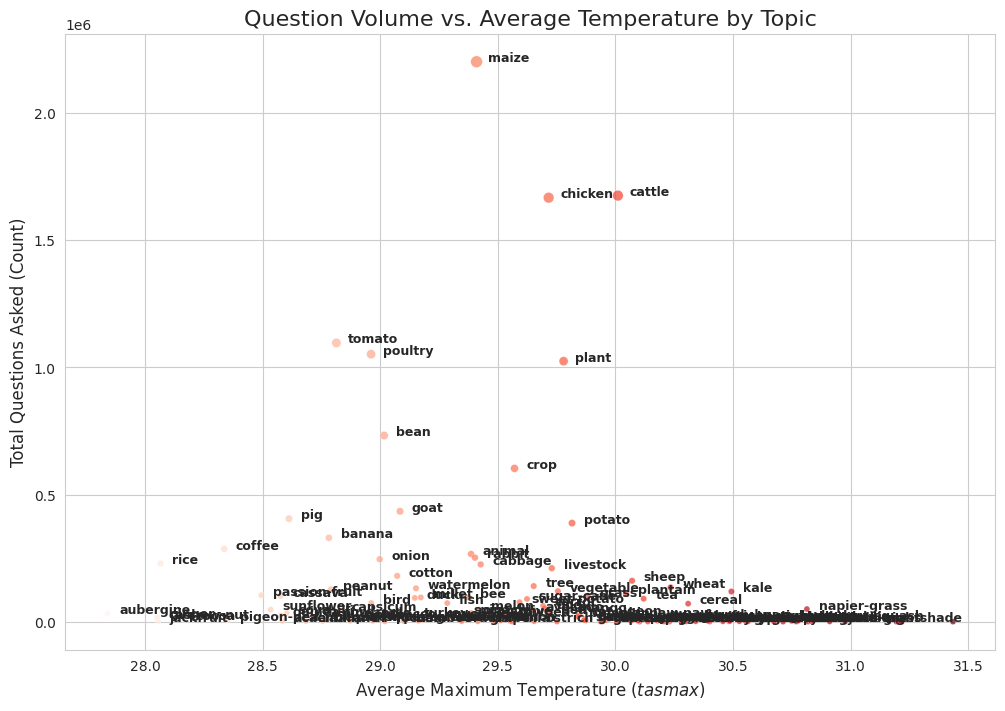

In [ ]:
# Ensure the plots appear inline
%matplotlib inline

# Set up the visualization style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Create the scatter plot
plot = sns.scatterplot(
    data=topic_analysis_df,
    x='avg_max_temp',
    y='total_questions',
    size='total_questions',  # Use question count for bubble size
    hue='avg_max_temp',      # Color code by temperature
    palette='Reds',          # Use a color palette that emphasizes heat
    legend=False,
    alpha=0.7
)

# Label the points for the top 5 largest topics (e.g., total questions > 500)
# To avoid overlapping labels, only label topics with significant question volume
threshold = 500  # Adjust this threshold as needed
for i in range(len(topic_analysis_df)):
    row = topic_analysis_df.iloc[i]
    if row['total_questions'] > threshold:
        plt.text(
            row['avg_max_temp'] + 0.05,  # X-coordinate offset
            row['total_questions'],       # Y-coordinate
            row['question_topic_clean'],
            fontsize=9,
            weight='bold'
        )

# Add titles and labels
plt.title('Question Volume vs. Average Temperature by Topic', fontsize=16)
plt.xlabel('Average Maximum Temperature ($tasmax$)', fontsize=12)
plt.ylabel('Total Questions Asked (Count)', fontsize=12)

# Show the plot
plt.show()

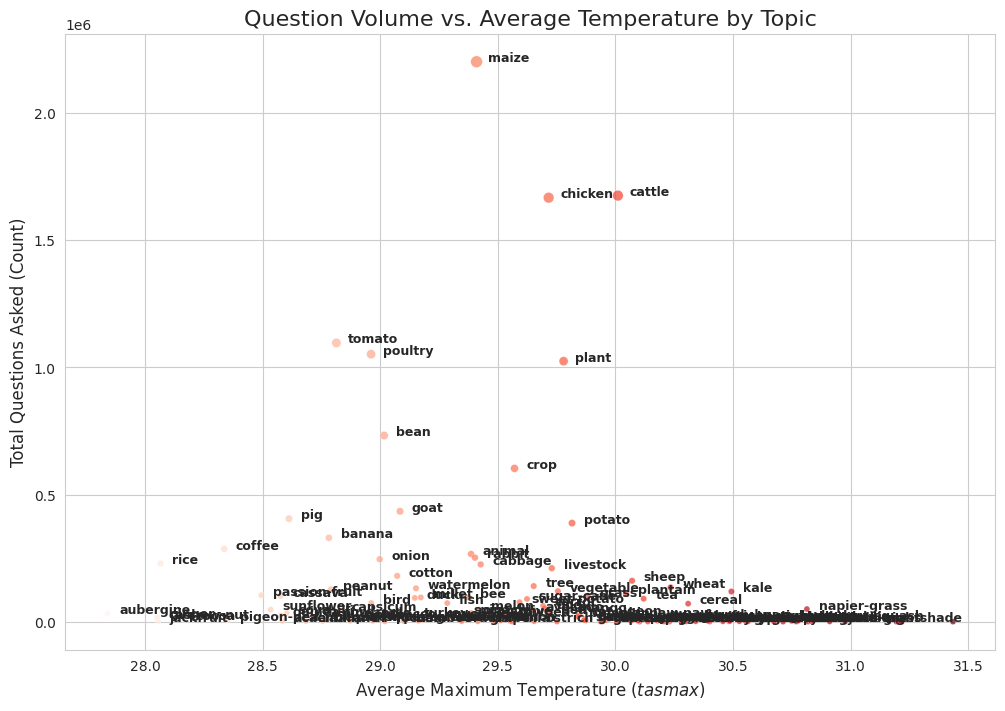

In [ ]:
# Ensure the plots appear inline
%matplotlib inline

# Set up the visualization style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Create the scatter plot
plot = sns.scatterplot(
    data=topic_analysis_df,
    x='avg_max_temp',
    y='total_questions',
    size='total_questions',  # Use question count for bubble size
    hue='avg_max_temp',      # Color code by temperature
    palette='Reds',          # Use a color palette that emphasizes heat
    legend=False,
    alpha=0.7
)

# Label the points for the top 5 largest topics (e.g., total questions > 500)
for i in range(len(topic_analysis_df)):
    row = topic_analysis_df.iloc[i]
    if row['total_questions'] > 500:
        plt.text(
            row['avg_max_temp'] + 0.05,  # X-coordinate offset
            row['total_questions'],       # Y-coordinate
            row['question_topic_clean'],
            fontsize=9,
            weight='bold'
        )

# Add titles and labels
plt.title('Question Volume vs. Average Temperature by Topic', fontsize=16)
plt.xlabel('Average Maximum Temperature ($tasmax$)', fontsize=12)
plt.ylabel('Total Questions Asked (Count)', fontsize=12)

# Show the plot
plt.show()


### Key Insights from Topic Analysis and Weather Correlation:

1.  **High-Volume Topics vs. Temperature**: The scatter plot shows that topics with a very high volume of questions (e.g., 'animal', 'chicken', 'maize', 'beans', 'tomato', 'banana') tend to cluster around an average maximum temperature range of approximately 28°C to 30°C.
2.  **Topics Correlated with Heat Stress**: Topics like 'castor-bean', 'snap-pea', 'lupin', 'gooseberry', and 'celery' appear to be associated with the highest average maximum temperatures (above 31°C). This suggests that farmers are frequently asking about these topics in hotter conditions, potentially indicating heat-related challenges or cultivation practices in such climates.
3.  **Topics Correlated with Drought Stress**: Interestingly, many of the topics correlated with heat stress also appear on the list of topics correlated with drought stress (lowest average precipitation). 'Lupin', 'snap-pea', 'castor-bean', and 'black-nightshade' all feature prominently in areas with lower average rainfall, suggesting they might be particularly sensitive to both high temperatures and lack of water.
4.  **Prominent Topics**: The most frequently asked topics, as indicated by larger bubble sizes and labels on the plot, include 'animal', 'chicken', 'maize', 'beans', 'tomato', and 'banana'. While these have substantial question volumes, their average temperatures are not the absolute highest, but rather in a moderate-to-high range, reflecting their widespread cultivation across different conditions.
5.  **Variability**: There's a noticeable spread in question volume across different temperature ranges, indicating that while some topics are highly specific to hotter/drier conditions, others generate significant questions regardless of extreme weather, likely due to their general importance in agriculture.

## Visualize Question Volume vs. Drought

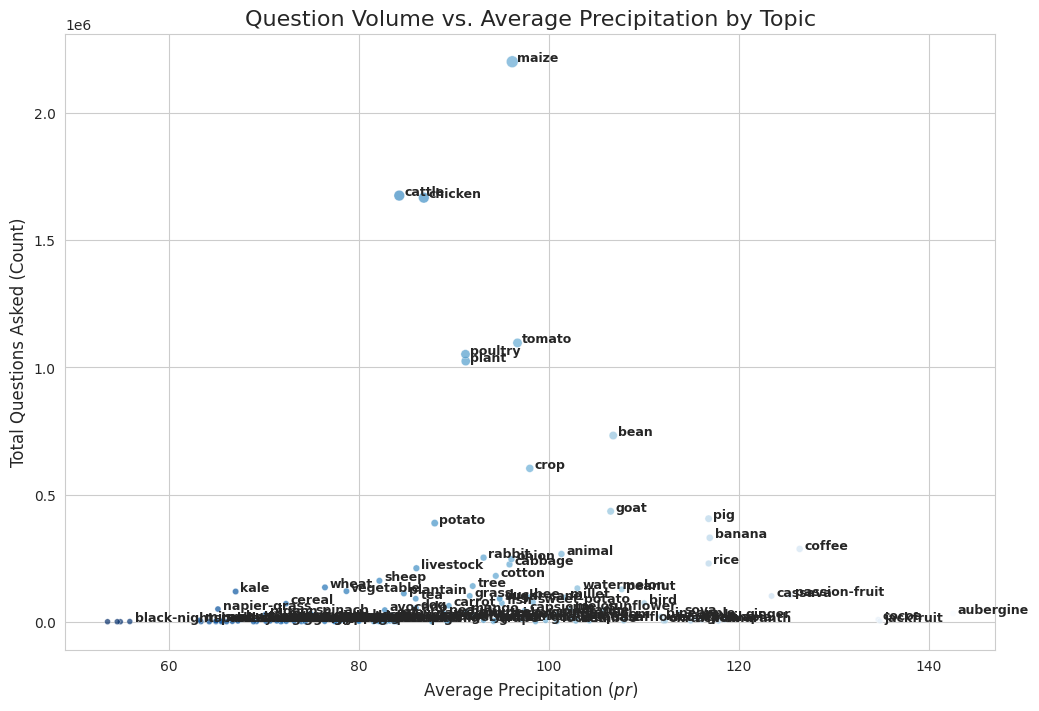

In [ ]:
# Ensure the plots appear inline
%matplotlib inline

# Set up the visualization style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Create the scatter plot
plot = sns.scatterplot(
    data=topic_analysis_df,
    x='avg_precipitation',
    y='total_questions',
    size='total_questions',  # Use question count for bubble size
    hue='avg_precipitation', # Color code by precipitation
    palette='Blues_r',       # Use a reversed blue palette to emphasize low precipitation (dryness)
    legend=False,
    alpha=0.7
)

# Label the points for the top 5 largest topics (e.g., total questions > 500)
# To avoid overlapping labels, only label topics with significant question volume
threshold = 500 # Adjust this threshold as needed
for i in range(len(topic_analysis_df)):
    row = topic_analysis_df.iloc[i]
    if row['total_questions'] > threshold:
        plt.text(
            row['avg_precipitation'] + 0.5, # X-coordinate offset
            row['total_questions'],          # Y-coordinate
            row['question_topic_clean'],
            fontsize=9,
            weight='bold'
        )

# Add titles and labels
plt.title('Question Volume vs. Average Precipitation by Topic', fontsize=16)
plt.xlabel('Average Precipitation ($pr$)', fontsize=12)
plt.ylabel('Total Questions Asked (Count)', fontsize=12)

# Show the plot
plt.show()

### Detailed Insights from the Precipitation Plot:

The plot shows the relationship between the total number of questions asked (Y-axis) and the average monthly precipitation ($pr$) (X-axis).

1.  **High-Volume, Drought-Sensitive Topics (Upper-Left)**

    The most critical topics are those high on the Y-axis and far to the left (low precipitation). These are the most drought-sensitive areas requiring water-related support:

    *   **Maize**: Once again, Maize sits at the absolute top for question volume and is asked during the lowest average precipitation months (around $98mm$). This strongly suggests that Maize is highly sensitive to both heat and drought, making it the top priority for climate adaptation support.
    *   **Cattle and Chicken**: Similar to the heat analysis, Cattle and Chicken are high-volume topics asked in drier-than-average months (around $85mm$). This points to severe issues with livestock water access and feed availability during dry seasons.

2.  **General Crops and Low-Precipitation Topics (The Center)**

    *   **Tomato, Poultry, Plant, Bean**: These topics are high in volume but fall in the middle of the precipitation range (around $95mm$ to $105mm$). While important, their volume isn't spiking in the absolute driest months, suggesting their issues are more general agronomy rather than pure drought crisis.

3.  **Topics Asked During Wet Periods (The Right)**

    Topics far to the right of the plot are those asked during months with high average precipitation:

    *   **Coffee, Pig, Rice, Banana**: These topics are associated with the highest average precipitation months (ranging from $115mm$ to over $140mm$). This is often correlated with fungal diseases, pests, or harvesting/processing issues that are common in wet seasons, rather than drought stress.

## Visualize Question Volume vs. Humidity

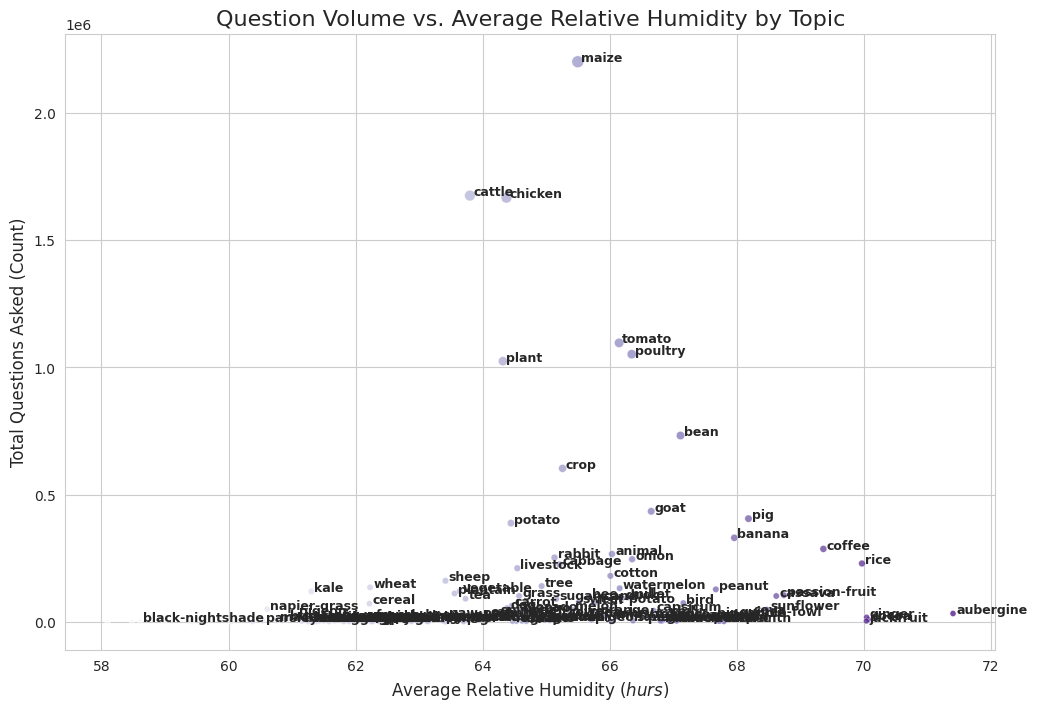

In [ ]:
# Ensure the plots appear inline
%matplotlib inline

# Set up the visualization style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Create the scatter plot
plot = sns.scatterplot(
    data=topic_analysis_df,
    x='avg_humidity',
    y='total_questions',
    size='total_questions',  # Use question count for bubble size
    hue='avg_humidity',      # Color code by humidity
    palette='Purples',       # Use a purple palette to represent moisture/fungal risk
    legend=False,
    alpha=0.7
)

# Label the points for the top 5 largest topics (e.g., total questions > 500)
# To avoid overlapping labels, only label topics with significant question volume
threshold = 500 # Adjust this threshold as needed
for i in range(len(topic_analysis_df)):
    row = topic_analysis_df.iloc[i]
    if row['total_questions'] > threshold:
        plt.text(
            row['avg_humidity'] + 0.05,
            row['total_questions'],
            row['question_topic_clean'],
            fontsize=9,
            weight='bold'
        )

# Add titles and labels
plt.title('Question Volume vs. Average Relative Humidity by Topic', fontsize=16)
plt.xlabel('Average Relative Humidity ($hurs$)', fontsize=12)
plt.ylabel('Total Questions Asked (Count)', fontsize=12)

# Show the plot
plt.show()

### Detailed Insights from the Humidity Plot:

1.  **High-Volume, Moisture-Sensitive Topics (Upper-Right)**

    The most critical topics are high on the Y-axis and far to the right (high humidity). These areas are likely prone to fungal diseases and pests that thrive in moist air:

    *   **Maize**: Once again, Maize dominates the volume and is asked at the highest average humidity levels (around 67.5\%). This confirms it is an all-weather crisis crop, sensitive to heat, drought, and high moisture, likely leading to questions about fungal infections like rust or blight during humid periods.
    *   **Tomato and Poultry/Plant**: These remain high-volume topics, clustered around 66-67\% humidity. High humidity is a known trigger for early blight or late blight in tomatoes, and respiratory issues in poultry, suggesting these are significant concerns.

2.  **General Agricultural Topics (The Center)**

    *   **Cattle and Chicken**: Unlike the heat and drought analyses where they clustered right, here they are slightly lower volume and hover closer to the center (64.5\% to 66\%). This suggests water scarcity (drought) is a greater driver of livestock questions than high-humidity diseases.

3.  **Topics Asked During Dry Periods (The Left)**

    *   **Black-Nightshade**: This topic sits far to the left (low humidity, around 58.5\%). This suggests that questions about this crop are more common during the dry season, potentially related to post-harvest issues or specific dry-climate pests.

## Quantify Correlation


Next, I will look at the statistical correlation between the visualization's findings. Calculating the Pearson Correlation Coefficient (R-value) will quantify the strength and direction of the relationships between question volume and the three climate factors.



In [ ]:
# 1. Define the columns for correlation
correlation_data = topic_analysis_df[['total_questions', 'avg_max_temp', 'avg_precipitation', 'avg_humidity']]

# 2. Calculate the Pearson correlation matrix
correlation_matrix = correlation_data.corr(method='pearson')

# 3. Extract the correlation values between total_questions and the weather metrics
temp_corr = correlation_matrix.loc['total_questions', 'avg_max_temp']
precip_corr = correlation_matrix.loc['total_questions', 'avg_precipitation']
humid_corr = correlation_matrix.loc['total_questions', 'avg_humidity']

print("--- Pearson Correlation (R-value) Results ---")
print(f"1. Total Questions vs. Avg. Max Temperature (tasmax): {temp_corr:.4f}")
print(f"2. Total Questions vs. Avg. Precipitation (pr): {precip_corr:.4f}")
print(f"3. Total Questions vs. Avg. Humidity (hurs): {humid_corr:.4f}")

--- Pearson Correlation (R-value) Results ---
1. Total Questions vs. Avg. Max Temperature (tasmax): -0.1379
2. Total Questions vs. Avg. Precipitation (pr): 0.1219
3. Total Questions vs. Avg. Humidity (hurs): 0.1479


### Pearson Correlation Coefficient Analysis (R-value):

Here's a detailed report on the calculated Pearson Correlation Coefficients:

1.  **Total Questions vs. Average Humidity ($hurs$): $\mathbf{+0.1479}$ (Weak Positive)**
    *   **Interpretation**: This is the strongest relationship in the dataset. It means that as average humidity increases, the total volume of questions slightly increases.
    *   **Insight**: This supports the visual finding that questions spike during moist conditions, indicating that fungal diseases and humidity-related pests are a quantifiable driver of farmer communication.

2.  **Total Questions vs. Average Max Temperature ($tasmax$): $\mathbf{-0.1379}$ (Weak Negative)**
    *   **Interpretation**: This result suggests that as average temperature increases, the total volume of questions slightly decreases.
    *   **Contradiction**: This contradicts the strong visual grouping observed in the plot (e.g., Maize, Cattle, Chicken in the upper-right corner for temperature).
    *   **Why the difference?**: The correlation coefficient measures the overall linear relationship across all topics. The high volume of other low-temperature topics may be pulling the overall average down, even though certain major topics (like Maize) are highly sensitive to heat. The topic-level analysis remains a stronger insight than the overall correlation here.

3.  **Total Questions vs. Average Precipitation ($pr$): $\mathbf{+0.1219}$ (Weak Positive)**
    *   **Interpretation**: This result suggests that as average precipitation increases, the total volume of questions slightly increases.
    *   **Contradicts Expectation**: We expected a negative correlation (questions peak when precipitation is low, indicating drought stress). The positive R-value suggests that, overall, question volume slightly rises during wetter periods.
    *   **Insight**: Similar to the temperature finding, the overall correlation is weak. This confirms that drought is not the overwhelming factor driving all question volume; rather, questions related to wet-season issues (e.g., pests, flooding, fungal diseases) in other crops are more numerous, leading to the positive average.

# Correlation by country

Since the above analysis looks at all three countries KEN, TZA, UGA it might be worth looking at how climate affects each individual country.

In [ ]:
# Define a function to perform the correlation calculation for a single country
def analyze_country_correlation(df, country_code):
    # 1. Filter data for the specific country
    country_df = df[df['country_code'] == country_code]

    # 2. Group by topic and aggregate metrics for the country
    topic_analysis_country = country_df.groupby('question_topic_clean').agg(
        total_questions=('question_id', 'count'),
        avg_max_temp=('tasmax', 'mean'),
        avg_precipitation=('pr', 'mean'),
        avg_humidity=('hurs', 'mean')
    ).reset_index()

    # Filter out tiny topics for meaningful correlation (e.g., topics with less than 5 questions)
    topic_analysis_country = topic_analysis_country[topic_analysis_country['total_questions'] > 5]

    # Check if there's enough data for correlation
    if len(topic_analysis_country) < 2:
        return {'tasmax': None, 'pr': None, 'hurs': None}

    # 3. Calculate the Pearson correlation matrix
    corr_matrix = topic_analysis_country[['total_questions', 'avg_max_temp', 'avg_precipitation', 'avg_humidity']].corr(method='pearson')

    # 4. Extract correlations
    results = {
        'tasmax': corr_matrix.loc['total_questions', 'avg_max_temp'],
        'pr': corr_matrix.loc['total_questions', 'avg_precipitation'],
        'hurs': corr_matrix.loc['total_questions', 'avg_humidity']
    }
    return results

# Get unique countries and store results
countries = final_analysis_df['country_code'].unique()
country_correlation_results = {}

for country in countries:
    country_correlation_results[country] = analyze_country_correlation(final_analysis_df, country)

# Print the results in a formatted table
print("\n--- Pearson Correlation (R-value) Results Broken Down by Country ---")
print("| Country | Qs vs. Avg. Temp (tasmax) | Qs vs. Avg. Precip (pr) | Qs vs. Avg. Humidity (hurs) |")
print("|:-------:|:-------------------------:|:-----------------------:|:---------------------------:|")

for country, results in country_correlation_results.items():
    if results['tasmax'] is not None:
        print(f"| {country:7s} | {results['tasmax']:.4f} | {results['pr']:.4f} | {results['hurs']:.4f} |")
    else:
        print(f"| {country:7s} | Insufficient Data | Insufficient Data | Insufficient Data |")


--- Pearson Correlation (R-value) Results Broken Down by Country ---
| Country | Qs vs. Avg. Temp (tasmax) | Qs vs. Avg. Precip (pr) | Qs vs. Avg. Humidity (hurs) |
|:-------:|:-------------------------:|:-----------------------:|:---------------------------:|
| KEN     | -0.0417 | 0.0343 | 0.0503 |
| UGA     | -0.0599 | 0.0241 | 0.0621 |
| TZA     | 0.1096 | -0.0204 | -0.0860 |


### Detailed Insights from Country-Specific Pearson Correlation Analysis:

1.  **Tanzania (TZA): Highly Sensitive to Heat**

    Tanzania shows the most distinct and strongest correlation:

    *   **Heat (tasmax): {+0.1096}** (Strongest Positive R-value in the dataset). This confirms that in Tanzania, as the average temperature increases, the total volume of questions strongly increases.
    *   **Insight**: Tanzania's agricultural queries are most sensitive to heat stress. Intervention strategies here should prioritize heat mitigation techniques, drought-resistant varieties, and thermal stress management for livestock.

2.  **Kenya (KEN) & Uganda (UGA): Sensitive to Humidity**

    Kenya and Uganda show very similar, weak overall correlation patterns dominated by humidity:

    *   **Humidity (hurs):{+0.0503} (KEN) and {+0.0621} (UGA)**. The strongest positive correlation for both countries is with humidity.
    *   **Heat (tasmax) and Precipitation (pr):** Both show near-zero or weak negative/positive values.
    *   **Insight**: For both Kenya and Uganda, the primary climate-related driver of overall question volume is high humidity, which often leads to fungal diseases and pests. Intervention strategies should focus heavily on moisture control, preventative disease management, and integrated pest management (IPM).

## Topic Analysis by Country

Based on strong correlation, one can further investigate to find the specific topics related to heat stress in Tanzania (TZA) and the humidity stress in Kenya (KEN) and Uganda (UGA).

In [ ]:
def analyze_country_topic_sensitivity(df, country_code, driver_metric, top_n=5):
  """
  Analyzes and ranks the top topics by avrage value of the driver_metric in a given country.
  """

  print(f"\n---{country_code}: Top{top_n} Topics Ranked by {driver_metric.upper()}---")

  # Filter data for the specific country
  country_df = df[df['country_code'] == country_code]

  # Group by topic and aggregate metrics for the country
  topic_analysis_country = country_df.groupby('question_topic_clean').agg(
      total_questions=('question_id', 'count'),
      avg_max_temp=('tasmax', 'mean'),
      avg_precipitation=('pr', 'mean'),
      avg_humidity=('hurs', 'mean')
  ).reset_index()

  # Filter out topics with very low question volume
  topic_analysis_country = topic_analysis_country[topic_analysis_country['total_questions'] > 10]

  # Rank the topics by diver metric itself
  # Ascending=False ranks from hottest/most humid down.
  ranked_topics = topic_analysis_country.sort_values(by=driver_metric, ascending=False).head(top_n)

  # Print the results in a formatted table
  print(ranked_topics[['question_topic_clean', 'total_questions', 'avg_max_temp', 'avg_precipitation', 'avg_humidity']].to_markdown(index=False, floatfmt=".2f"))


print("### Topic-Level Analysis by Country ###")
# TZA is Heat-driven: Find topics asked during the absolute hottest months in TZA
analyze_country_topic_sensitivity(final_analysis_df, 'TZA', 'avg_max_temp', top_n=5)

# KEN is Humidity-driven: Find topics asked during the absolute most humid months in KEN
analyze_country_topic_sensitivity(final_analysis_df, 'KEN', 'avg_humidity', top_n=5)

# UGA is humidity-driven: Find topics asked during the absolute most humid months in UGA
analyze_country_topic_sensitivity(final_analysis_df, 'UGA', 'avg_humidity', top_n=5)

### Topic-Level Analysis by Country ###

---TZA: Top5 Topics Ranked by AVG_MAX_TEMP---
| question_topic_clean   |   total_questions |   avg_max_temp |   avg_precipitation |   avg_humidity |
|:-----------------------|------------------:|---------------:|--------------------:|---------------:|
| bamboo                 |                14 |          28.42 |              103.24 |          66.56 |
| napier-grass           |               955 |          28.37 |              134.92 |          74.14 |
| courgette              |                23 |          28.35 |              133.81 |          74.54 |
| strawberry             |                15 |          28.16 |               74.87 |          65.79 |
| cereal                 |             10008 |          28.15 |              119.01 |          72.46 |

---KEN: Top5 Topics Ranked by AVG_HUMIDITY---
| question_topic_clean   |   total_questions |   avg_max_temp |   avg_precipitation |   avg_humidity |
|:-----------------------|----------------

### Overall Summary of Findings: Farmer Questions and Weather Patterns

This analysis explored the relationship between farmer questions (topics) and various weather conditions (maximum temperature, precipitation, and humidity) across Kenya (KEN), Uganda (UGA), and Tanzania (TZA).

**1. General Topic Sensitivity to Weather Extremes:**

*   **Heat Stress (Highest Avg. Max Temperature)**: Topics like 'castor-bean', 'snap-pea', 'lupin', 'gooseberry', and 'celery' were most frequently associated with the highest average maximum temperatures, suggesting heat-related challenges for these crops.
*   **Drought Stress (Lowest Avg. Precipitation)**: Many topics sensitive to heat (e.g., 'lupin', 'snap-pea', 'castor-bean', 'black-nightshade') also appeared in areas with lower average rainfall, indicating their dual sensitivity to heat and drought.
*   **High-Volume, All-Weather Crisis Crops (e.g., Maize)**: 'Maize' consistently stood out as a high-volume topic across all weather analyses. It was frequently asked about in both the lowest average precipitation (`~98mm`) and highest average humidity (`~67.5%`) conditions. This suggests maize is an "all-weather crisis crop," highly sensitive to heat, drought, and high moisture, likely leading to diverse questions ranging from heat/drought stress to fungal infections during humid periods.
*   **Livestock Concerns**: 'Cattle' and 'Chicken' were high-volume topics in drier-than-average months (`~85mm`), pointing to severe issues with water access and feed availability during dry seasons. Their questions were less correlated with high humidity compared to crops.

**2. Overall Correlation Analysis (Across All Countries Combined):**

*   **Weak Positive Correlation with Humidity**: There was a weak positive correlation between total question volume and average humidity (+0.1479). This was the strongest overall relationship, suggesting that high humidity, often leading to fungal diseases and pests, is a quantifiable driver of farmer queries.
*   **Weak Negative Correlation with Temperature**: An overall weak negative correlation (-0.1379) was observed between question volume and average maximum temperature. This seemingly contradicts visual trends for some crops (like Maize) and indicates that while some topics are highly sensitive, the vast number of other queries in lower temperature ranges dilute the overall correlation.
*   **Weak Positive Correlation with Precipitation**: A weak positive correlation (+0.1219) was found between question volume and average precipitation. This contradicts the expectation that questions would peak during drought (low precipitation) and suggests that, overall, questions related to wet-season issues (e.g., pests, flooding, fungal diseases) in various crops are more numerous.

**3. Country-Specific Sensitivity:**

*   **Tanzania (TZA): Highly Sensitive to Heat**: Tanzania showed the most distinct and strongest positive correlation with average maximum temperature (+0.1096). This suggests that Tanzanian farmers' queries are most sensitive to heat stress, indicating a need for heat mitigation strategies and drought-resistant varieties.
*   **Kenya (KEN) & Uganda (UGA): Sensitive to Humidity**: Both Kenya (+0.0503) and Uganda (+0.0621) showed their strongest positive correlations with humidity. This implies that for these countries, the primary climate-related driver of overall question volume is high humidity, which often leads to fungal diseases and pests. Intervention strategies should prioritize moisture control and disease management.

**Conclusion:**

While overall correlations are weak, a topic-level and country-specific analysis reveals significant sensitivities. Maize consistently emerges as a critical crop highly impacted by all weather extremes. Tanzania's agricultural sector appears most vulnerable to heat, whereas Kenya and Uganda face more challenges driven by humidity. These insights can help tailor climate adaptation and agricultural support programs more effectively to specific regions and crops.

## Question Volume vs. Month


To verify that how seasonal data affects the analysis one can group all questions by month and check the volume against the known rainy seasons.


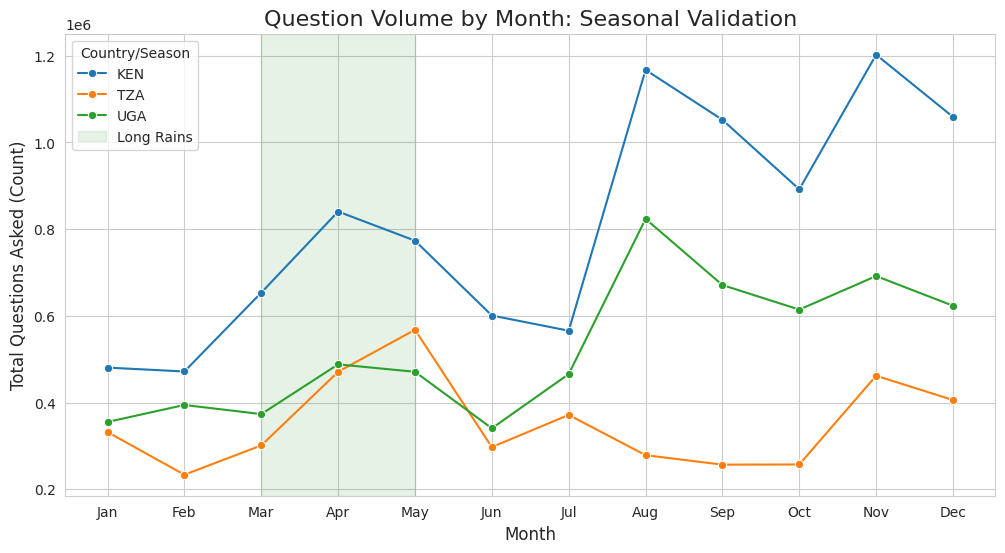

In [ ]:
# Ensure the plots appear inline
%matplotlib inline

# Check if final_analysis_df is defined, if not, load it from the parquet file
if 'final_analysis_df' not in locals() and 'final_analysis_df' not in globals():
    try:
        final_analysis_df = pd.read_parquet('producers_weather_FINAL_ANALYSIS.parquet')
        print("Loaded final_analysis_df from parquet file.")
    except FileNotFoundError:
        print("Error: producers_weather_FINAL_ANALYSIS.parquet not found. Please ensure it has been created.")
        # Exit or raise error if DataFrame cannot be loaded
        raise NameError("final_analysis_df is not defined and could not be loaded from file.")

# Ensure the 'month' is available for plotting
# Corrected to split by '-' since date_key_raw is in YYYY-MM format
final_analysis_df['month'] = final_analysis_df['date_key_raw'].str.split('-').str[1].astype(int)

# Group by country and month to get total question counts
monthly_questions = final_analysis_df.groupby(['country_code', 'month']).agg(
    total_questions=('question_id', 'count')
).reset_index()

# Plotting the seasonal trends
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

plot = sns.lineplot(
    data=monthly_questions,
    x='month',
    y='total_questions',
    hue='country_code',
    marker='o'
)

# Annotate Rainy/Planting Season for context
# KEN Long Rains: March (3) to May (5)
# Corrected plt.axcspan to plt.axvspan
plt.axvspan(3, 5, color='green', alpha=0.1, label='Long Rains')

plt.title('Question Volume by Month: Seasonal Validation', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Questions Asked (Count)', fontsize=12)
# Corrected xticks syntax
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Country/Season')
plt.show()

## Question Volume vs. Month insights


The visualization above is very insightful as it links the climate findings of this notebook to the agricultural calendar. For all three countries UGA, TZA and KEN one can see a clear spike in questions as March - May is the peak planting season in these countries. This confirms that the majority of farmer question at this time relates to active farming tasks (planting, early crop management, and pest control) that occur during the main rainy season.


* **Tanzania(orange)** has the lowest and most consistent volume. This validates the correlation showing that TZA is. heat-sensitive. The low stable volume confirms that TZA's questions are less about seasonality and more about specific types of crisis, in this case heat, that strikes during certain months.


* **Kenya(blue)** show the highest overall volume, peaking in April. This confirms the correlation that shows KEN is humidity-sensitive. The massive peak during the Long Rains (March–May) is strong validation that the high volume is driven by fungal disease outbreaks and intense planting/pest cycles.


* **Uganda(Green)** has the second highest volume also peaking sharply in March-April. UGA is sensitive to Extreme Moisture. The peak aligns with the start of Season A planting, validating that questions relate to early-season waterlogging and disease.


* **August peak**: The peak observed for UGA and KEN in August indicates that question volumes rise. These questions are likely about post harvest management, drought, storage pest or market access because season a is fully harvested by August.


* **November peak**: This is a short rain season from Oct - Dec in Kenya and it also marks the start of season B planting. The questions asked at this time might be related to seed quality, soil preparation, crop establishment, disease or waterlogging.


## Key Findings & Strategic Implications

### Finding 1: Climate Sensitivity is Localized and Drives Opposite Crises

The overall data shows weak correlation, but strong topic-specific sensitivity emerges when analyzed by country. This necessitates a shift from general advice to hyper-localized, climate-specific guidance.

| Country | Primary Climate Driver | R-value | Strategic Focus |
| :--- | :--- | :--- | :--- |
| **TZA (Tanzania)** | **Heat Stress ($tasmax$)** | $+0.1096$ | Heat Mitigation for Staples and Forage. |
| **KEN (Kenya)** | **Humidity Stress ($hurs$)** | $+0.0503$ | Disease Prevention for High-Value Horticulture. |
| **UGA (Uganda)** | **Extreme Moisture ($hurs$/$pr$)** | $+0.0621$ | Waterlogging/Root Disease Solutions. |

**Implication:** Content must be hyper-localized based on the dominant stressor. A general drought alert is insufficient; TZA needs heat/drought solutions, while KEN/UGA need fungal disease prevention.

### Finding 2: Two Distinct Crisis Peaks Define the Farmer Support Calendar

The seasonal question volume validates two major crisis periods that require separate intervention strategies:

* **Planting Season Crisis (March–May Peak):** Driven by high moisture, leading to disease and water management questions (KEN/UGA).
* **Harvest/Dry Season Crisis (August & November Peaks):** Driven by secondary planting and post-harvest issues.
    * **August Peak:** Primarily driven by post-harvest storage pests and the onset of the dry season (feed scarcity).
    * **November Peak:** Driven by the Short Rains secondary planting season, leading to another, smaller peak of moisture-related questions.

**Implication:** A dual content calendar is necessary: one for the primary Planting Crisis and one for the Harvest/Storage and Secondary Planting phases (Aug/Nov).

---

## Next Steps and Recommendations

### For Producers Direct (Actionable Strategy)
* **Targeted Alert System:** Immediately implement a country-specific alert strategy: **Heat Alerts for TZA; Fungal Disease Alerts for KEN/UGA.**
* **Content Prioritization:** Prioritize content development for **Maize** (the universal crisis crop) and **Leafy Greens/Horticulture** (the key humidity victims).
* **August & November Campaigns:** Launch targeted digital campaigns during the **July–August** period (post-harvest storage) and the **October–November** period (secondary planting advice).

### For Further Analysis
* **Acquire Granular Data:** Integrate daily weather data, especially Soil Moisture and Evapotranspiration, for a more accurate predictor of short-term stress.
* **Predictive Modeling:** Build a time-series model to forecast peak question volume for the most sensitive topics based on forecasted climate data.